In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from scipy import ndimage

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
 def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


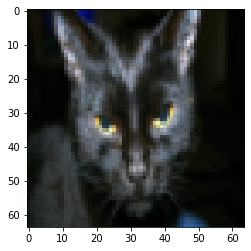

In [4]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [5]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [6]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0] , -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0] , -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [7]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [8]:
def sigmoid(z):
    
    s = 1/( 1 + np.exp(-z))
    
    return s

In [9]:
def initialize_with_zeros(dim):
    
    w= np.zeros((dim , 1))
    b = float(0)
    
    return w, b

In [10]:
def propagate(w, b, X, Y):
    
    m = X.shape[1]
    
    A = sigmoid( np.dot(w.T , X) + b)
    cost = -(np.dot(Y , np.log(A).T) + np.dot(1-Y , np.log(1-A).T))/m

    dw = np.dot(X , (A-Y).T) / m
    db = np.sum(A-Y) / m
    
    cost = np.squeeze(np.array(cost))

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [11]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):

    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w= w - learning_rate*dw
        b= b - learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
        
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [12]:
def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid ( np.dot(w.T , X) + b)
    
    for i in range(A.shape[1]):
        
        if A[0, i] > 0.5 :
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
        
        
    return Y_prediction

In [13]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    
    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w , b , X_train , Y_train , num_iterations, learning_rate, print_cost) 
    w = params["w"]
    b = params["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    return d

In [14]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.01, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.823921
Cost after iteration 200: 0.418944
Cost after iteration 300: 0.617350
Cost after iteration 400: 0.522116
Cost after iteration 500: 0.387709
Cost after iteration 600: 0.236254
Cost after iteration 700: 0.154222
Cost after iteration 800: 0.135328
Cost after iteration 900: 0.124971
Cost after iteration 1000: 0.116478
Cost after iteration 1100: 0.109193
Cost after iteration 1200: 0.102804
Cost after iteration 1300: 0.097130
Cost after iteration 1400: 0.092043
Cost after iteration 1500: 0.087453
Cost after iteration 1600: 0.083286
Cost after iteration 1700: 0.079487
Cost after iteration 1800: 0.076007
Cost after iteration 1900: 0.072809
train accuracy: 99.52153110047847 %
test accuracy: 70.0 %


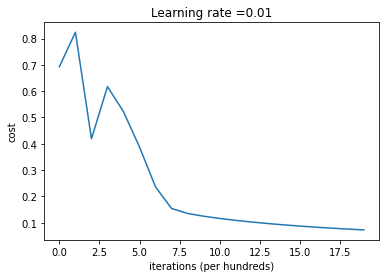

In [15]:
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

Training a model with learning rate: 0.01

-------------------------------------------------------

Training a model with learning rate: 0.001

-------------------------------------------------------

Training a model with learning rate: 0.0001

-------------------------------------------------------



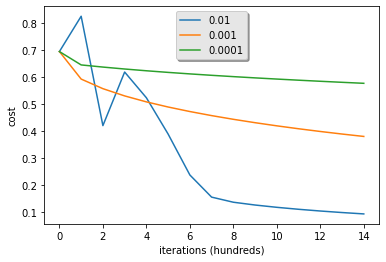

In [16]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()